# ICA em sinais temporais

## Carregando pacotes

In [1]:
import numpy as np
from sklearn.decomposition import FastICA, PCA
from scipy import signal

from picard import Picard

import matplotlib.pyplot as plt
import mplhep as hep

import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, FloatSlider, IntSlider, Dropdown, Checkbox


import warnings

from src.data_utils import toy_time
from src.misc import colors
from src.jadeR import jadeR
from src.gradient_models import *

%load_ext autoreload
%autoreload 2

### Configurando o ambiente

In [2]:
# Setting plot style (optional)
hep.style.use(hep.style.ATLAS)

# Random seeds for reproducibility
np.random.seed(0)

## Signal Descriptions

We generate three types of signals for the ICA demonstration:

1. **Sinusoidal Signal**:
   - This signal is a basic sine wave, mathematically represented by:
   \[
   s_1(t) = \sin(2t)
   \]
   where \( t \) is time. This type of signal is continuous and smooth, representing periodic oscillations.

2. **Square Signal**:
   - This signal switches between high and low states without any transition, creating a square wave pattern. It is represented as:
   \[
   s_2(t) = \text{sgn}(\sin(3t))
   \]
   where \(\text{sgn}\) is the sign function, making the output +1 or -1 depending on the sign of \(\sin(3t)\).

3. **Sawtooth Signal**:
   - The sawtooth wave ramps upward and then sharply drops. Mathematically, it can be described by:
   \[
   s_3(t) = \text{sawtooth}(2\pi t)
   \]
   This function creates a linear rise with a discontinuous drop, used often to represent signals that reset periodically.

### Mixing the Signals

The signals are then mixed using a matrix \( \mathbf{A} \) to simulate real-world data collection where multiple signals are combined. The mixing matrix \( \mathbf{A} \) is:
\[
\mathbf{A} = \begin{bmatrix}
    1 & 1 & 1 \\
    0.5 & 2 & 1.0 \\
    1.5 & 1.0 & 2.0 \\
\end{bmatrix}
\]

The mixed signal \( \mathbf{X} \) is then obtained by:
\[
\mathbf{X} = \mathbf{S} \mathbf{A}^T
\]
where \( \mathbf{S} \) is the matrix of original signals and \( \mathbf{A}^T \) is the transpose of the mixing matrix.


In [3]:
# n_samples = 2000
# S, A, X = toy_time(n_samples, noise_amp)

def plot_ica(noise_amp, n_samples, n_components, algorithm, fun):
    S, A, X = toy_time(n_samples, noise_amp)
    ica = FastICA(n_components=n_components, algorithm=algorithm, fun=fun)
    S_ = ica.fit_transform(X)  # Reconstruct signals
    A_ = ica.mixing_  # Get estimated mixing matrix

    plt.figure(figsize=(9, 6))
    models = [X, S, S_]
    names = ['Mixed signals', 'True signals', 'Recovered signals after ICA']

    for ii, (model, name) in enumerate(zip(models, names), 1):
        plt.subplot(3, 1, ii)
        plt.title(name)
        for sig, color in zip(model.T, colors):
            plt.plot(sig, color=color)
    plt.tight_layout()
    plt.show()

interact(plot_ica,
         noise_amp=FloatSlider(min=0.0, max=1.0, step=0.1, value=0.1),
         n_samples=IntSlider(min=1000, max=5000, step=500, value=2000),
         n_components=IntSlider(min=1, max=5, step=1, value=3),
         algorithm=Dropdown(options=['parallel', 'deflation'], value='parallel'),
         fun=Dropdown(options=['logcosh', 'exp', 'cube'], value='logcosh'))

interactive(children=(FloatSlider(value=0.1, description='noise_amp', max=1.0), IntSlider(value=2000, descript…

<function __main__.plot_ica(noise_amp, n_samples, n_components, algorithm, fun)>

## Application of FastICA

`FastICA` is applied to the corrupted signal to attempt to recover the original signals. This is performed using different non-linear functions (`g-functions`):

- **logcosh**: The default and generally robust to variations in signal.
- **exp**: also robust
- **cube**: FastICA using kurtosis. Too sensitive to outliers

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from scipy import signal
import ipywidgets as widgets
from IPython.display import display

# Set random seed for reproducibility
np.random.seed(0)

def update_plot(num_outliers):
    n_samples = 2000
    S, A, X = toy_time(n_samples, noise_amp=0.2, num_spike_outliers=num_outliers)

    plt.rcParams.update({'font.size': 8})  # Adjust font size globally
    fig, axes = plt.subplots(4, 3, figsize=(12, 8), sharex=True)  # Adjust the figure size
    for j in range(3):
        axes[0, j].plot(X[:, j], label='With Outliers', color='#FF6347')
        axes[0, j].set_title(f'Mixed Signal {j+1} with Outliers')
        axes[0, j].legend()

    for i, g_func in enumerate(['logcosh', 'exp', 'cube'], start=1):
        ica = FastICA(n_components=3, fun=g_func, random_state=0)
        S_recovered = ica.fit_transform(X)
        for j in range(3):
            axes[i, j].plot(S_recovered[:, j], label=f'Recovered with {g_func}', color='#4682B4')
            axes[i, j].set_title(f'Recovered Signal {j+1} using {g_func}')
            axes[i, j].legend()
    
    plt.tight_layout()
    plt.show()

outlier_slider = widgets.IntSlider(value=1, min=0, max=200, step=1, description='Outliers:')
interactive_plot = widgets.interactive(update_plot, num_outliers=outlier_slider)
display(interactive_plot)


interactive(children=(IntSlider(value=1, description='Outliers:', max=200), Output()), _dom_classes=('widget-i…

## JADE

In [5]:

def plot_ica(noise_amp, n_samples, n_components):
    S, A, X = toy_time(n_samples, noise_amp)
    
    # Apply JADE using jadeR
    B = jadeR(X.T, m=n_components, verbose=True)  # B is the unmixing matrix
    S_ = B @ X.T  # Recover signals
    A_ = B # for standardization

    S_ = np.asarray(S_.T) # np.matrix -> np.array
    
    plt.figure(figsize=(9, 6))
    models = [X, S, S_]
    names = ['Mixed signals', 'True signals', 'Recovered signals after JADE ICA']
    print(S_)
    for ii, (model, name) in enumerate(zip(models, names), 1):
        plt.subplot(3, 1, ii)
        plt.title(name)
        for sig, color in zip(model.T, colors):
            plt.plot(sig, color=color)
    plt.tight_layout()
    plt.show()

interact(plot_ica,
         noise_amp=FloatSlider(min=0.0, max=1.0, step=0.1, value=0.1),
         n_samples=IntSlider(min=1000, max=5000, step=500, value=2000),
         n_components=IntSlider(min=1, max=5, step=1, value=3))


interactive(children=(FloatSlider(value=0.1, description='noise_amp', max=1.0), IntSlider(value=2000, descript…

<function __main__.plot_ica(noise_amp, n_samples, n_components)>

## Picard

O artigo "Faster Independent Component Analysis by Preconditioning with Hessiana Approximations" introduz o algoritmo Picard, que é uma nova abordagem para melhorar a eficiência e precisão da Análise de Componentes Independentes (ICA). Aqui está uma síntese focando nos pontos principais solicitados:

### Ponto Principal
O objetivo principal do artigo é abordar a convergência lenta e a alta demanda computacional dos métodos tradicionais de ICA, especialmente em conjuntos de dados grandes ou complexos onde os modelos padrão podem não se ajustar bem. Os autores propõem o algoritmo Picard, um método otimizado de ICA que usa técnicas de otimização precondicionadas para melhorar o desempenho.

### O Algoritmo Picard
Picard significa Preconditioned ICA for Real Data. É um método avançado de quasi-Newton que incorpora a otimização L-BFGS precondicionada com aproximações da Hessiana. Este método captura efetivamente a curvatura da paisagem de otimização, tornando a convergência mais rápida e mais robusta contra as não idealidades em dados do mundo real.

### Integração de Maximum Likelihood e Infomax
- **Maximum Likelihood**: Picard aprimora a abordagem tradicional de máxima verossimilhança para ICA ao otimizar a função de verossimilhança com L-BFGS precondicionado, uma técnica que aproveita informações de curvatura anteriores para melhorar a precisão e velocidade do passo atual.
- **Infomax**: Enquanto o Infomax tradicional usa uma abordagem de gradiente estocástico que pode exigir ajuste extensivo e convergir lentamente, Picard usa uma abordagem determinística que melhora sistematicamente o Infomax estabilizando e acelerando sua convergência através de uma melhor exploração da estrutura de dados.

### Uso da Hessiana
- **Aproximações**: O algoritmo não utiliza a Hessiana completa devido ao seu custo computacional, mas emprega aproximações esparsas. Essas aproximações são calculadas sob a suposição de que os sinais estimados atuais são independentes, simplificando a Hessiana em uma forma que é computacionalmente mais barata de inverter.
- **Precondicionamento**: Essas aproximações da Hessiana são usadas para precondicionar o algoritmo L-BFGS, efetivamente guiando o processo de otimização ao fornecer uma melhor estimativa da curvatura local da superfície de verossimilhança. Isso é crucial para acelerar a convergência e garantir estabilidade em cenários de otimização não convexos típicos da ICA.

### Resumo
O algoritmo Picard aborda várias questões-chave nos métodos tradicionais de ICA integrando técnicas matemáticas avançadas e otimizações. Seu uso de aproximações da Hessiana para precondicionamento, combinado com uma estrutura de otimização robusta L-BFGS, permite superar os métodos existentes, particularmente no tratamento de dados em grande escala e complexos típicos em campos como neurociência e processamento de sinais. Isso o torna uma contribuição valiosa para a aprendizagem de máquina não supervisionada, especialmente em aplicações onde a qualidade dos dados e recursos computacionais são preocupações significativas.


In [6]:
# n_samples = 2000
# S, A, X = toy_time(n_samples, noise_amp)

def plot_ica(noise_amp, n_samples, n_components, extended, ortho):
    S, A, X = toy_time(n_samples, noise_amp)
    ica = Picard(n_components=n_components, extended=extended, ortho=ortho, random_state=0, fun="logcosh", whiten="unit-variance")
    S_ = ica.fit_transform(X)  # Reconstruct signals
    A_ = ica.mixing_  # Get estimated mixing matrix

    plt.figure(figsize=(9, 6))
    models = [X, S, S_]
    names = ['Mixed signals', 'True signals', 'Recovered signals after ICA']

    for ii, (model, name) in enumerate(zip(models, names), 1):
        plt.subplot(3, 1, ii)
        plt.title(name)
        for sig, color in zip(model.T, colors):
            plt.plot(sig, color=color)
    plt.tight_layout()
    plt.show()

interact(plot_ica,
         noise_amp=FloatSlider(min=0.0, max=1.0, step=0.1, value=0.1),
         n_samples=IntSlider(min=1000, max=5000, step=500, value=2000),
         n_components=IntSlider(min=1, max=5, step=1, value=3),
         extended=Checkbox(description="Extended", value=False),
         ortho=Checkbox(description="Ortho", value=False))

interactive(children=(FloatSlider(value=0.1, description='noise_amp', max=1.0), IntSlider(value=2000, descript…

<function __main__.plot_ica(noise_amp, n_samples, n_components, extended, ortho)>

## Gradient : not working

Iteration 1, Component 3, Metric: 0.14397107918097754, Gamma: -0.8076523008566951
Iteration 101, Component 3, Metric: 0.14396926022655898, Gamma: -114.59570230310672
Iteration 201, Component 3, Metric: 0.14396743657343605, Gamma: -228.383752338856
Iteration 301, Component 3, Metric: 0.14396560826582164, Gamma: -342.17180240897716
Iteration 401, Component 3, Metric: 0.14396377534820948, Gamma: -455.9598525143379


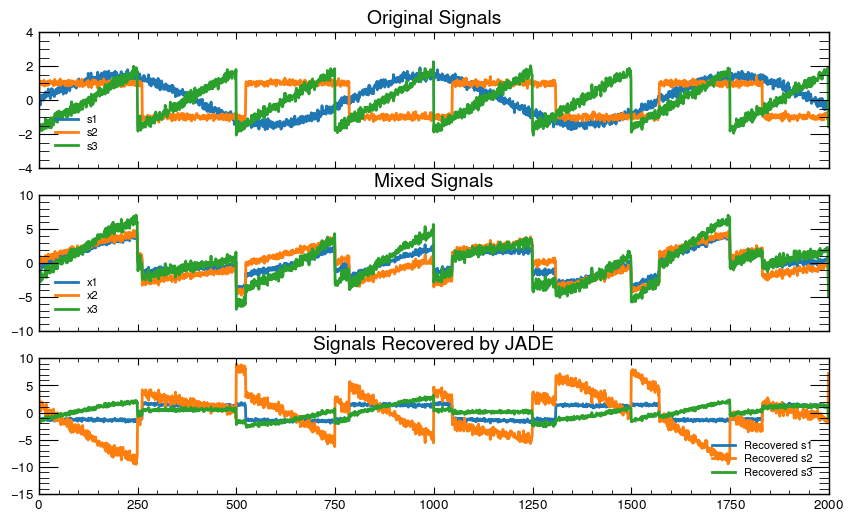

In [7]:
import numpy as np
n_samples = 2000
S, A, X = toy_time(n_samples, 0.1)

ica = GradientICA(n_components=3, max_iter=500, learning_rate=0.01, method='negentropy', g_func='g1', approach='deflationary', whiten=True)

ica.fit(X)
S_estimated = ica.transform(X)

# Plotting
fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
axes[0].plot(S, label=['s1', 's2', 's3'])
axes[0].set_title('Original Signals')
axes[0].legend()

axes[1].plot(X, label=['x1', 'x2', 'x3'])
axes[1].set_title('Mixed Signals')
axes[1].legend()

axes[2].plot(S_estimated, label=['Recovered s1', 'Recovered s2', 'Recovered s3'])
axes[2].set_title('Signals Recovered by JADE')
axes[2].legend()


## Natural Gradient ICA

Iteration 0: Weights updated. Diff -0.06958505816004293
Iteration 100: Weights updated. Diff -2.1828244450334656e-06


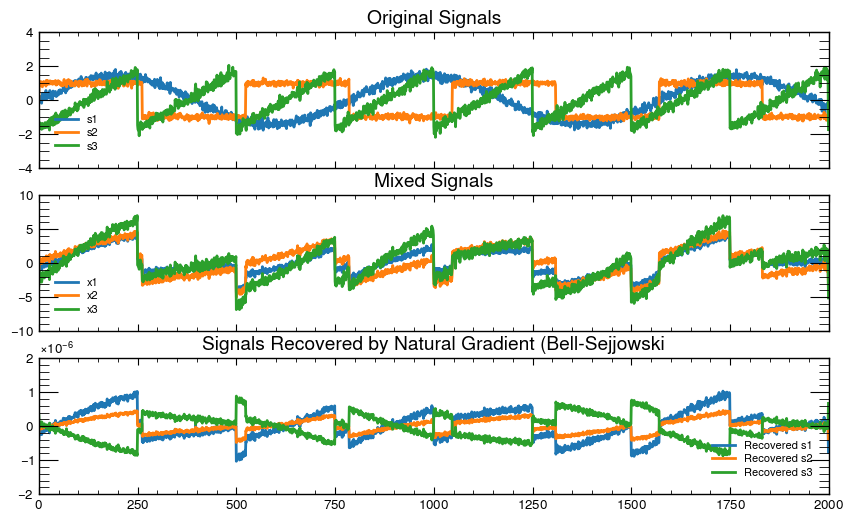

In [8]:
import numpy as np

S, A, X = toy_time(n_samples, 0.1)

ica = NaturalGradientICA(n_components=3, whiten=True, max_iter=5000, mu=.1, mu_gamma=.01)

ica.fit(X)
S_estimated = ica.transform(X)

# Plotting
fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
axes[0].plot(S, label=['s1', 's2', 's3'])
axes[0].set_title('Original Signals')
axes[0].legend()

axes[1].plot(X, label=['x1', 'x2', 'x3'])
axes[1].set_title('Mixed Signals')
axes[1].legend()

axes[2].plot(S_estimated, label=['Recovered s1', 'Recovered s2', 'Recovered s3'])
axes[2].set_title('Signals Recovered by Natural Gradient (Bell-Sejjowski')
axes[2].legend()


## Separação de fontes sonoras por ICA

O dataset carregado abaixo contém três misturas de 3 fontes sonoras distintas: uma ruído e duas de instrumentos musicais. Vamos estimar as fontes a partir das misturas usando os métodos discutidos.

In [9]:
from IPython.display import Audio, display
from pathlib import Path

# https://www.kaggle.com/datasets/chittalpatel/icamusical

datapath = Path("datasets/music")
# List of audio file paths
audio_files = ['ICA mix 1.wav', 'ICA mix 2.wav', 'ICA mix 3.wav']
audio_files = [datapath / file for file in audio_files]

for audio_file in audio_files:
    print(audio_file)
    display(Audio(audio_file))

datasets/music/ICA mix 1.wav


datasets/music/ICA mix 2.wav


datasets/music/ICA mix 3.wav


In [10]:
import wave
audios = [wave.open(str(file), 'r') for file in audio_files]
audios[0].getparams()

signals = [audio.readframes(-1) for audio in audios]
signals = [np.frombuffer(signal, dtype=np.int16) for signal in signals]

X = np.vstack(signals).T

#### Vamos visualizar as misturas no tempo, acompanhado de suas "distribuições marginais" à direita

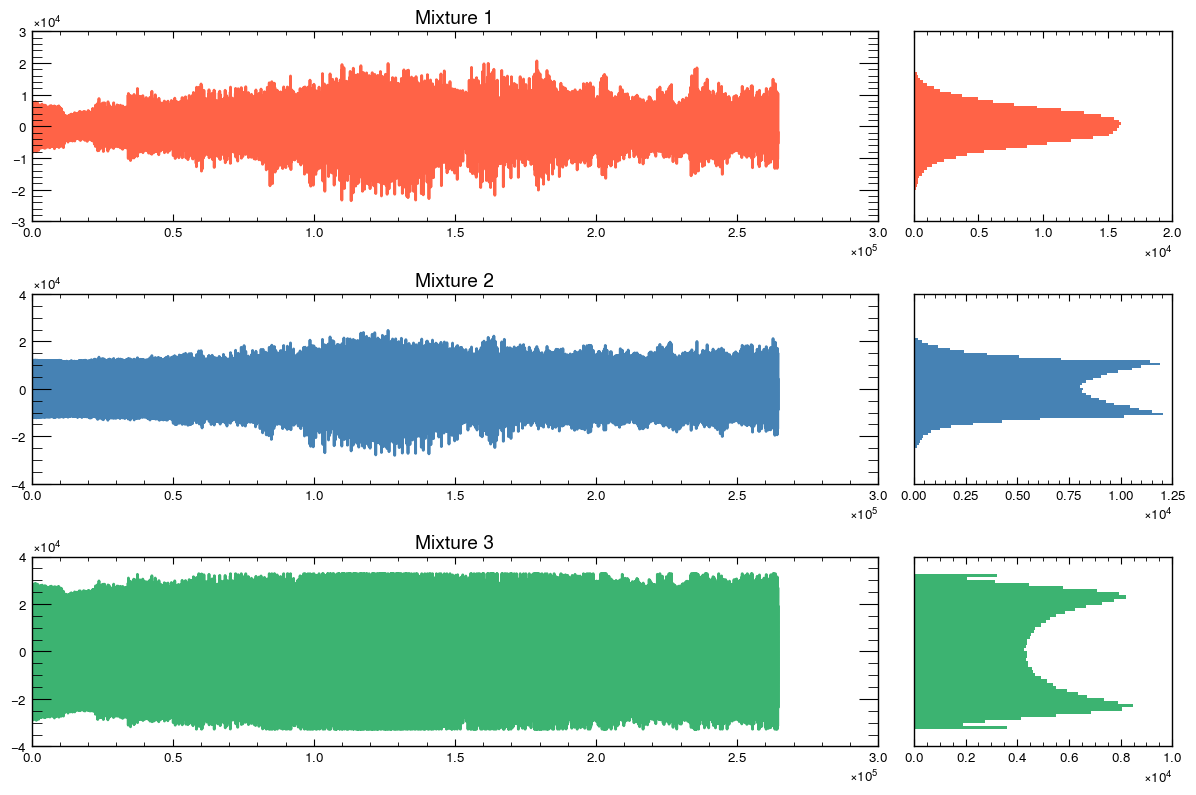

In [11]:

signal = signals[0]
fs = audios[0].getframerate()
timing = np.linspace(0, len(signal)/fs, num=len(signal))

plt.figure(figsize=(12, 8))

for i in range(3):
    # Create axis for the time series plot
    ax_time_series = plt.subplot2grid((3, 4), (i, 0), colspan=3)
    ax_time_series.plot(X[:, i], color=colors[i])
    ax_time_series.set_title(f"Mixture {i + 1}")
    
    # Create axis for the histogram
    ax_hist = plt.subplot2grid((3, 4), (i, 3), colspan=1)
    ax_hist.hist(X[:, i], bins=50, orientation='horizontal', color=colors[i])
    ax_hist.set_ylim(ax_time_series.get_ylim())  # Sync y-limits with time series plot

    # Hide y-axis labels and ticks to avoid duplication
    ax_hist.yaxis.set_visible(False)

    # Adjust the width of the histogram plot to make it narrower
    ax_hist.set_xlim(0, ax_hist.get_xlim()[1])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

#### Aplicando ICA (escolha seu algorítmo)

In [12]:

# ica = FastICA(n_components=3, random_state=0, whiten='unit-variance') 
ica = Picard(n_components=3, extended=True, ortho=True, random_state=0, fun="logcosh", whiten="unit-variance")

# Fit the model to the mixed signals
S_ = ica.fit_transform(X)

#### Visualizando as fontes estimadas

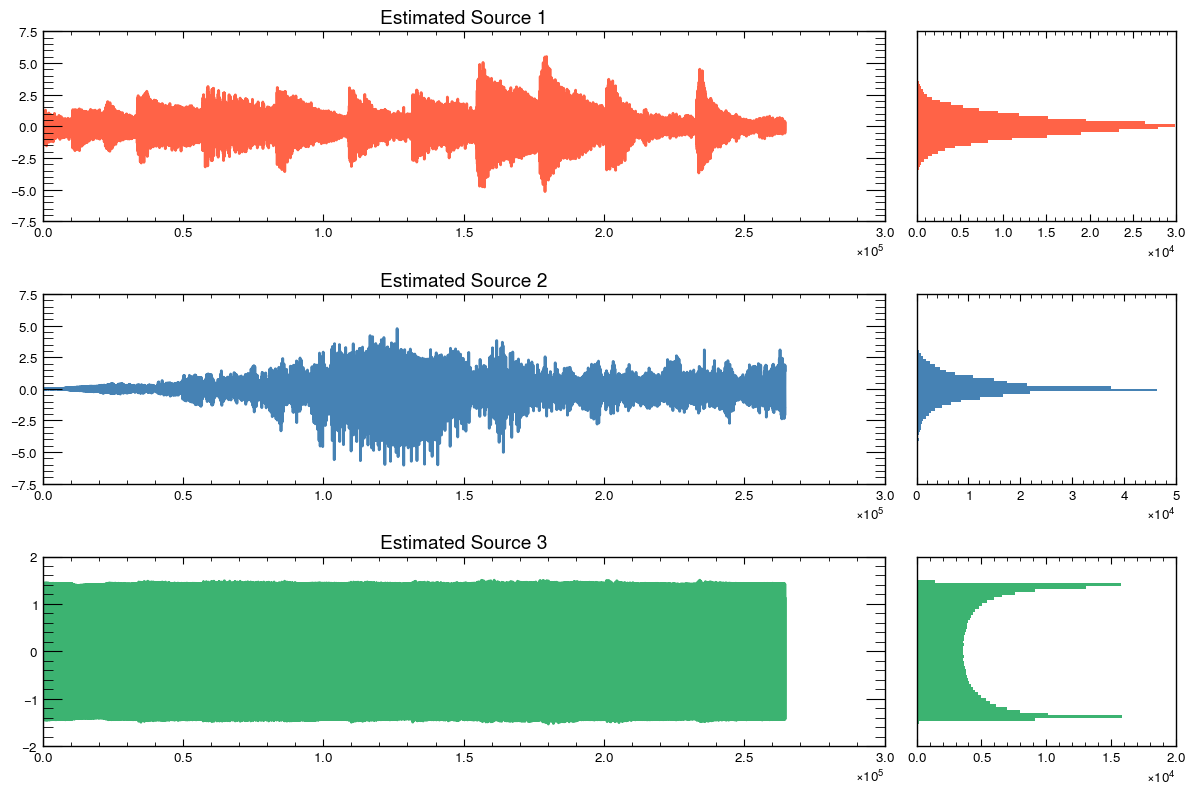

In [13]:

plt.figure(figsize=(12, 8))  

for i in range(3):
    # Create axis for the time series plot
    ax_time_series = plt.subplot2grid((3, 4), (i, 0), colspan=3)
    ax_time_series.plot(S_[:, i], color=colors[i])
    ax_time_series.set_title(f"Estimated Source {i + 1}")
    
    # Create axis for the histogram
    ax_hist = plt.subplot2grid((3, 4), (i, 3), colspan=1)
    ax_hist.hist(S_[:, i], bins=50, orientation='horizontal', color=colors[i])
    ax_hist.set_ylim(ax_time_series.get_ylim())  # Sync y-limits with time series plot

    # Hide y-axis labels and ticks to avoid duplication
    ax_hist.yaxis.set_visible(False)

    # Adjust the width of the histogram plot to make it narrower
    ax_hist.set_xlim(0, ax_hist.get_xlim()[1])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

#### Ouvindo as fontes estimadas

In [14]:
# List of audio file paths
audio_files = [datapath / 'est_source_1.wav', datapath /  'est_source_2.wav', datapath /  'est_source_3.wav']

# Display audio files vertically
for i in range(3):
    print(f"Estimated source # {i}")
    display(Audio(S_[:, i], rate=fs))

Estimated source # 0


Estimated source # 1


Estimated source # 2
